# TAX-FREE SAVINGS ACCOUNT Project

by Alexandros Taderera

### Objective:
- South Africa's Tax Free Savings Account is an underserved market with macroeconomic potential. Use the tools and techniques I have been working on in the last few months and probe for opportunities to unlock value.
   

### Steps:
1) Data Processing
- Scrape assets availible on the EasyEquities platform then download price data from Yahoo API

2) #### Machine Learning Model
- Use a sparse covarriance matrix to determine significant covarriance relations amongst assets and ignore the rest. Find assets not in a cluster, referred to as Risk-Independent assets

3) #### Test the 'Pure Portfolio' of independent assets
- build equal risk contribution and equally weighted portfolios

4) #### Experiment
- Use random portfolio construction to test the impact of adding our Risk-Independent assets

In [1]:
# Import all the necessary packages

import numpy as np #for numerical array data
import pandas as pd #for tabular data
import matplotlib.pyplot as plt #for plotting purposes
import seaborn as sns
import csv
from datetime import datetime, timedelta

from sklearn import cluster, covariance, manifold
from matplotlib.collections import LineCollection #for plotting purposes

#hypothesis tests
import scipy.stats as stats
import math

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import the self-defined functions from the python file
from Graphical_Analysis_functions import *
import portfolio_analyzer as pa

In [3]:
%load_ext autoreload
%autoreload 2

### Step 1:  Data Processing
- Scrape assets availible on the EasyEquities platform then download price data from Yahoo API


In [446]:
firms_info.head(10)

,institution,fund_name,fund_type,asset_class,region,Sector,index_weighting_method,domestic_foreign,expenseratio,dividends,riskprofile,fundsize
STX40,Satrix,Satrix 40 ETF,ETF,Equity,South Africa,Blend,Market Cap,Domestic,0.10,Pays Dividends,Aggressive,R 10 877 670 722
ETFT40,1nvest,1nvest Top 40 ETF,ETF,Equity,South Africa,Blend,Market Cap,Domestic,0.29,Pays Dividends,Aggressive,R 809 887 251
NFTRCI,ABSA,NewFunds TRACI 3 Month ETF,ETF,Cash,South Africa,Government,Duration,Domestic,0.35,Reinvests Dividends,Conservative,R 234 537 091
STXPRO,Satrix,Satrix Property ETF,ETF,Real Estate,South Africa,Blend,Market Cap,Domestic,0.30,Pays Dividends,Aggressive,R 350 856 891
CSPROP,CoreShares,CoreShares SA Property Income ETF,ETF,Real Estate,South Africa,Blend,Market Cap,Domestic,0.47,Pays Dividends,Aggressive,R 261 342 563
GLPROP,CoreShares,CoreShares S&P Global Property ETF,ETF,Equity,Global,Blend,Market Cap,Foreign,0.54,Pays Dividends,Aggressive,R 521 863 076
STXRAF,Satrix,Satrix RAFI 40 ETF,ETF,Equity,South Africa,Blend,Fundamentals,Domestic,0.49,Reinvests Dividends,Aggressive,R 1 011 693 408
ASHEQF,Ashburton,Ashburton Global 1200 Equity Fund of Funds ETF,ETF,Equity,Global,Blend,Market Cap,Foreign,0.42,Pays Dividends,0,R 1 301 000 451
STXIND,Satrix,Satrix INDI ETF,ETF,Equity,South Africa,Blend,Market Cap,Domestic,0.43,Pays Dividends,Aggressive,R 2 187 961 687
STXWDM,Satrix,Satrix MSCI World ETF,ETF,Equity,Global,Blend,Market Cap,Foreign,0.35,Reinvests Dividends,Aggressive,R 5 776 156 704


In [5]:
# Get and print the Sector Information
Sectors = firms_info.Sector.unique()
print(Sectors)

['Blend' 'Government' 'Inflation Protected' 'Value'
 'Conservative Allocation' 'Preferred' 'Growth' 'Aggressive Allocation']


In [509]:
# Load Stock Return dataset 
file_name = 'CleanedData_TSFA_Daily.xlsx'
sheet_name = 'Stock Returns'
df = pd.read_excel(file_name, sheet_name, index_col=0)
df.index=pd.to_datetime(df.index)    
data = df.copy()['2018':'2021']
# data
# del data['AMIB50']

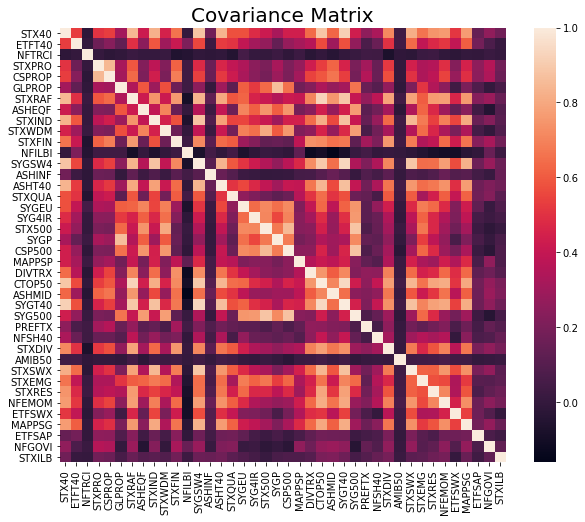

In [510]:
cov = data.corr()
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cov) # create seaborn heatmap
plt.title('Covariance Matrix', fontsize = 20) # title with fontsize 20
plt.show()


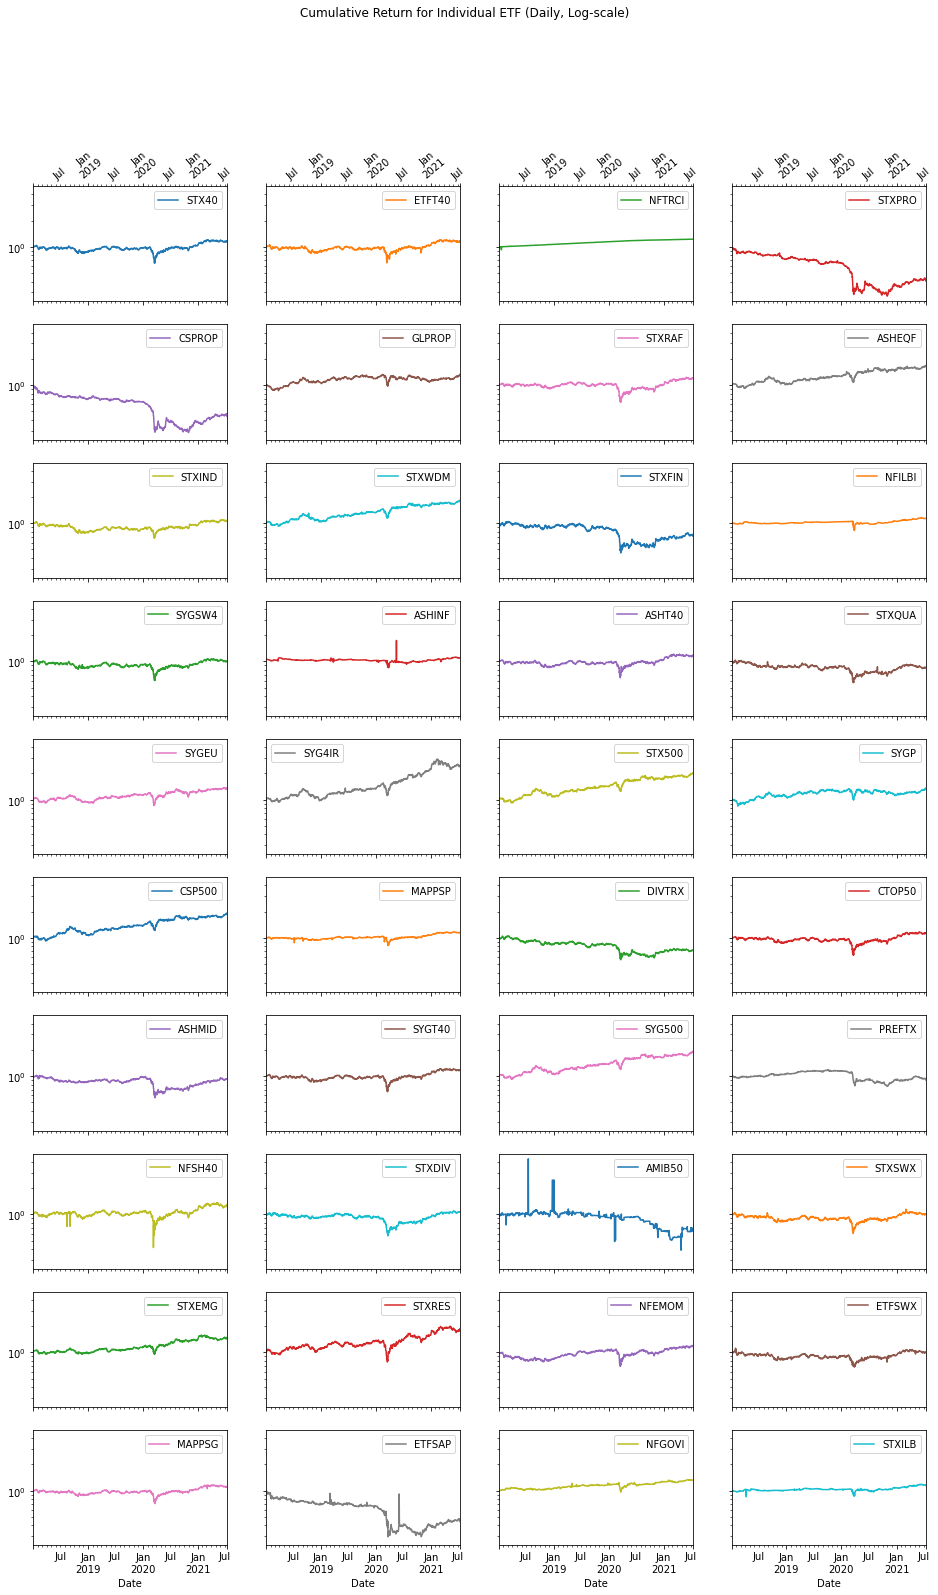

In [196]:
# Plot cumulative return for each firm
lo_col = 4
lo_row = int(np.ceil(len(df.columns)/4))
f_hei = lo_row * 2.5
f_wid = lo_col * 4
ax = (data+1).cumprod().plot(subplots=True, layout=(lo_row, lo_col), figsize=(f_wid, f_hei),
                             logy=True, sharex=True, sharey=True,
                             title='Cumulative Return for Individual ETF (Daily, Log-scale)');
for i in range(lo_col):
    ax[0,i].xaxis.set_tick_params(which='both', top = True, labeltop=True, labelrotation=40)
plt.show()

In [511]:
# Output the summary statistics of the data for the whole time period
getSumStat(data).head(20)

Summary Statistic Information from 01/01/2018 to 07/15/2021:


,Sector,Total Return(%),Ave Return(%),Annu. Ave Return(%),Annu. Std(%),Max Drawdown(%)
STX40,Blend,16.71,0.03,6.60,20.81,-37.25
ETFT40,Blend,16.84,0.03,8.10,26.61,-38.08
NFTRCI,Government,22.50,0.02,5.88,5.97,-7.56
STXPRO,Blend,-59.30,-0.08,-18.66,27.78,-72.53
CSPROP,Blend,-56.38,-0.08,-17.63,25.39,-71.29
GLPROP,Blend,31.75,0.04,9.71,18.67,-26.35
STXRAF,Blend,19.75,0.03,7.50,21.39,-41.67
ASHEQF,Blend,66.05,0.06,16.96,19.10,-24.27
STXIND,Blend,8.25,0.02,4.17,19.58,-35.20
STXWDM,Blend,81.82,0.07,20.13,20.07,-21.79


In [512]:
###########################################   CAN BE CHANGED  #############################################

start_date = '2018-01-02'
end_date   = '2019-01-03'

###########################################   CAN BE CHANGED  #############################################

2) #### Machine Learning Model
- Use a sparse covarriance matrix to determine significant covarriance relations amongst assets and ignore the rest. Find assets not in a cluster, referred to as Risk Independent assets


In [514]:
###########################################   CAN BE CHANGED  #############################################

## Start and End date we are considering:

start_date = '2018-01-02'
end_date   = '2019-01-03'

## Sectors which we will be testing:
Sectors_chosen = ['Blend', 'Government', 'Inflation Protected', 
                  'Value', 'Conservative Allocation', 'Preferred', 
                  'Growth', 'Aggressive Allocation']


## The list of firms we want to drop:
drop_firm = [] #['NFNAM.JO'] #, 'STXMNT.JO', 'USTXCN.JO']

## Whether we want to display the summary statisitcs and/or individual firm performance:
display_SumStat = True
display_IndRet = True

###########################################   CAN BE CHANGED  #############################################

Results over the time period  2018-01-02  to  2019-01-03 :

Sectors choosen in the Graphical Analysis are:
['Blend', 'Government', 'Inflation Protected', 'Value', 'Conservative Allocation', 'Preferred', 'Growth', 'Aggressive Allocation']

Number of firms examined: 40
Cluster 1: STX40, ETFT40, STXRAF, STXIND, SYGSW4, ASHT40, CTOP50, SYGT40, STXSWX, STXRES, ETFSWX, MAPPSG
Cluster 2: GLPROP, ASHEQF, STXWDM, SYGEU, STX500, SYGP, CSP500, SYG500, STXEMG, SYG4IR
Cluster 3: AMIB50
Cluster 4: STXPRO, CSPROP, ETFSAP
Cluster 5: NFTRCI
Cluster 6: NFILBI
Cluster 7: ASHINF
Cluster 8: STXILB
Cluster 9: PREFTX
Cluster 10: STXFIN, STXQUA, DIVTRX, ASHMID, NFSH40, STXDIV, NFGOVI, MAPPSP, NFEMOM


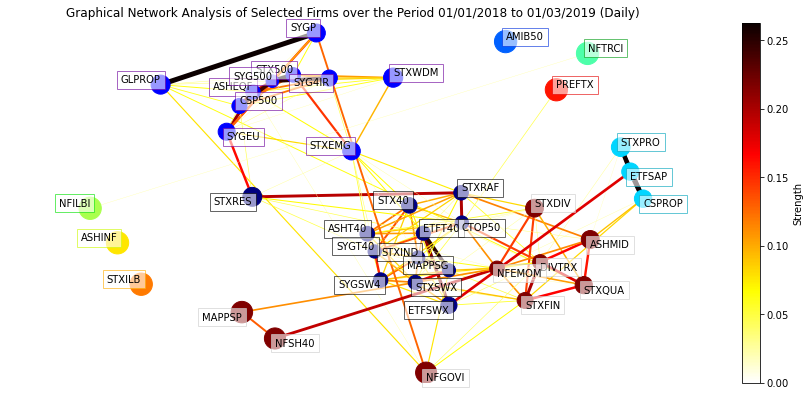

In [525]:
print('Results over the time period ', start_date, ' to ', end_date, ':')
print()

# Output the Clustering information, graphical network plot, 
# as well as summary statistics (optional) and the individual firm performance (optional)
# Store the correlation matrix and precision matrix in "est" (stands for estimates)
# Store the plotting configuration information in "con_fig" which will be needed if we want to use the ZOOM functions
## Note: you can view the correlation matrix by looking at est[0] and view the precision matrix by looking at est[1] 
est, con_fig = graphicalAnalysis(data, start_date, end_date, 
                                 Sectors_chosen, drop_firm, 
                                 display_SumStat = False, display_IndRet = False)

### Findings:
10 clusters were found in this period.
* note independent assets stayed the same over different modelling periods, this implies great robustness in this way or determining independence in a given universe

### Step 3
- Test the 'Pure Portfolios' of independent assets
- Build Equal Risk Contribution and Equally Weighted Portfolios

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
ASHINF,0.037816,0.593848,13.417650,445.147676,-0.450169,0.033265,0.017717,-0.468235
ETFSAP,-0.276171,1.035412,14.209706,385.487335,-0.753499,0.073068,-0.285142,-0.702011
NFGOVI,0.116249,0.170763,0.420762,32.804729,0.007881,0.020087,0.508942,-0.224119
NFILBI,0.052513,0.146015,-1.499202,125.481428,-0.003553,0.013430,0.170145,-0.214306
NFTRCI,0.083553,0.071861,2.308305,414.519188,-0.028107,0.003325,0.766346,-0.075554
PREFTX,-0.037780,0.168358,-1.289538,14.561181,0.015452,0.023708,-0.374692,-0.353671
STXILB,0.057473,0.225428,1.778286,160.023294,-0.024857,0.021571,0.131627,-0.187291


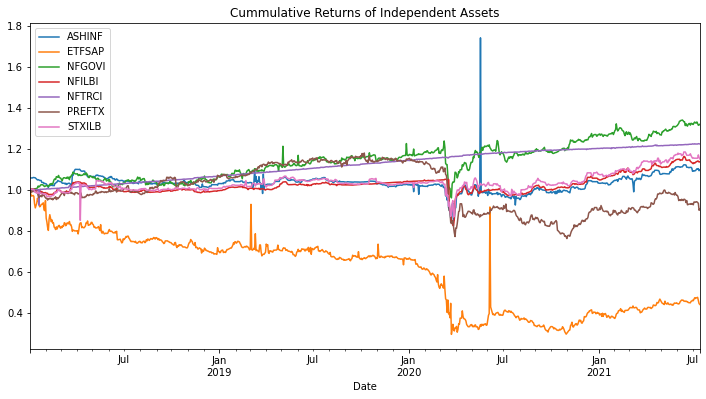

In [598]:
#Cumulative returns of independent assets
cum_rets = (rets['2018':] + 1).cumprod()
cum_rets[[ 'ASHINF', 'ETFSAP', 'NFGOVI', 'NFILBI', 'NFTRCI', 'PREFTX', 'STXILB']].plot(figsize=(12,6), title = 'Cummulative Returns of Independent Assets')

#performance
pa.summary_stats(rets)

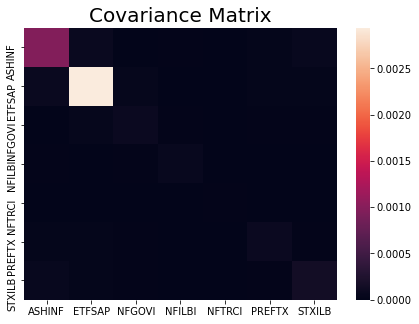

In [564]:
cov = rets.cov()
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(cov) # create seaborn heatmap
plt.title('Covariance Matrix', fontsize = 20) # title with fontsize 20
plt.show()

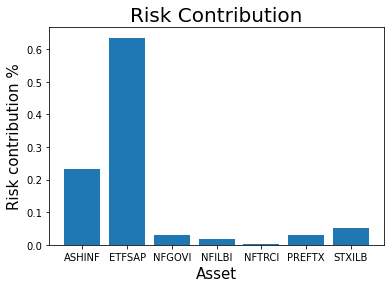

In [563]:
ax = plt.bar(pa.risk_contribution(w, cov).index, pa.risk_contribution(w, cov).tolist())

plt.title('Risk Contribution', fontsize = 20) # title with fontsize 20
plt.xlabel('Asset', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Risk contribution %', fontsize = 15) # y-axis label with fontsize 15

plt.show()



### Equal risk contribution portfoliio



In [565]:
# Equal weights
n = rets.shape[1]
w = np.repeat(1/n,n)
w

array([0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
       0.14285714, 0.14285714])

In [566]:
# Equal Risk Contribution Weights
erc_weights = pa.target_risk_contributions(w, cov).round(2)
erc_weights

array([0.04, 0.02, 0.13, 0.18, 0.39, 0.14, 0.1 ])

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.074019,0.071852,0.706615,36.535524,0.002646,0.008268,0.637228,-0.129962


<AxesSubplot:title={'center':'Equal Risk Contribution Portfolio'}, xlabel='Date', ylabel='Cummulative Return'>

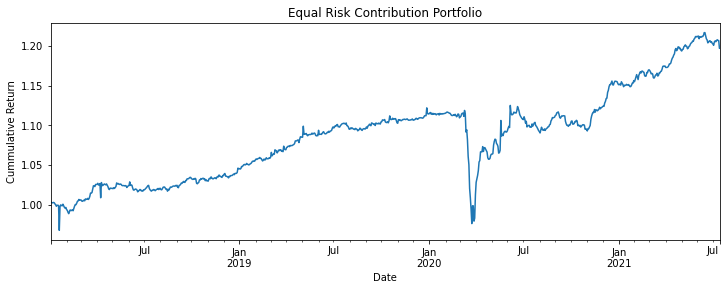

In [595]:
temp = (rets@erc_weights ).to_frame()
display(pa.summary_stats(temp))
((rets@erc_weights)+1).cumprod().plot(figsize=(12,4), title = 'Equal Risk Contribution Portfolio', ylabel = 'Cummulative Return')

### Equal weighted portfolio

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.073326,0.190298,7.801821,161.596039,-0.049188,0.017007,0.237052,-0.22182


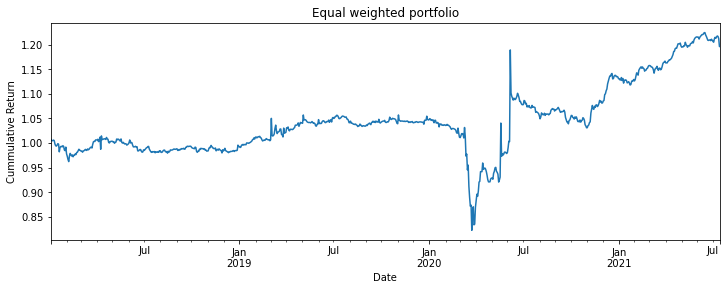

In [597]:
((rets@w)+1).cumprod().plot(figsize=(12,4), title = 'Equal weighted portfolio', ylabel = 'Cummulative Return')
temp = (rets@w ).to_frame()
pa.summary_stats(temp)

In [556]:
rets = data[[ 'ASHINF', 'ETFSAP', 'NFGOVI', 'NFILBI', 'NFTRCI', 'PREFTX', 'STXILB']]
rets

,ASHINF,ETFSAP,NFGOVI,NFILBI,NFTRCI,PREFTX,STXILB
Date,,,,,,,
2018-01-02,0.058944,-0.008462,0.000347,0.000299,0.000000,0.003663,0.003571
2018-01-03,0.000000,-0.013887,0.001040,0.002694,0.000435,-0.004866,0.001779
2018-01-04,0.000000,-0.007628,0.001732,0.003134,0.000000,-0.009780,-0.001776
2018-01-05,0.000000,0.001478,-0.000173,-0.002678,0.000000,0.004938,0.000000
2018-01-08,0.001936,0.001771,0.001902,0.000149,-0.000435,0.001229,0.000000
...,...,...,...,...,...,...,...
2021-07-09,0.004198,0.002727,0.003920,0.000263,0.000000,0.000000,0.000000
2021-07-12,-0.001393,0.003324,-0.006117,0.002630,0.000000,-0.003886,0.000000
2021-07-13,0.002326,-0.031928,-0.006154,-0.000393,0.001421,-0.003901,0.013910


### Step 4) Experiment
- Use random portfolio construction to test the impact of adding our independent assets

- The expected results are: portfolio performance drops, but risk-adjusted performance increases.

In [ ]:
#### build 2 random portfolios
# 1) random porfolio of 10 assets
# 2) same random porfolio as above, but with one of the assets being replaced with independent assets

treated_results = pd.DataFrame()
control_results = pd.DataFrame()
test_results = pd.DataFrame()

train_region, test_region = '2018', '2019'

i = 0
while i < 500: 
    
    #get random porfolios:
    random_universe = data.sample(n=10,axis='columns')
    random_uncorr = rets.sample(n=1,axis='columns')
    all_ass = random_universe.columns.tolist()
    test_ass = random_uncorr.columns.tolist()
    check = any(item in test_ass for item in all_ass)
    if check == True:
        pass

    test_port = random_universe.copy() #.append(random_uncorr)
    #keep portfolio size constant
    test_port = test_port.iloc[:,:-1]
    test_port['Uncorr'] = random_uncorr.copy()
    

    # Equal weights for control
    n = random_universe.shape[1]
    w = np.repeat(1/n,n)
    
    # Equal contribution for control
    cov = random_universe[train_region].cov()
    #w = pa.target_risk_congmvtributions(w, cov)
    w = pa.gmv(cov)
    
    
    #control_results
    control_results[i] = ((random_universe[test_region:]@w)+1).cumprod()
    
    # Equal weights for treated
    n = test_port.shape[1]
    w = np.repeat(1/n,n)

    # Equal contribution for treated
    cov = test_port[train_region].cov()
    #w = pa.target_risk_contributions(w, cov)
    w = pa.gmv(cov)
    
    #treated_results
    treated_results[i] = ((test_port[test_region:]@w)+1).cumprod()
    
    
    i = i+1
    
    
bins = np.linspace(-2, 2, 100)

fig, ax = plt.subplots(figsize = (12,6))
plt.hist(control_results.iloc[-1,:], bins, alpha=0.5, label='control')
plt.hist(treated_results.iloc[-1,:], bins, color = 'r', alpha=0.5, label='treated')
plt.legend(loc='upper right')
plt.show()
print(f'conrol mean: {control_results.iloc[-1,:].mean()}', f'\ntreated mean: {treated_results.iloc[-1,:].mean()}')
#plt.title('Covariance Matrix', fontsize = 20) # title with fontsize 20



In [434]:
diff = treated_results - control_results
diff_rets = treated_results.pct_change() - control_results.pct_change() 
diff_rets = diff_rets.dropna()

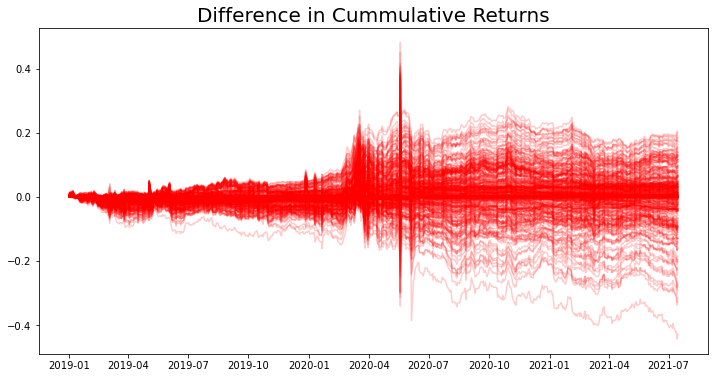

treated less control mean: -0.0010236837773600533


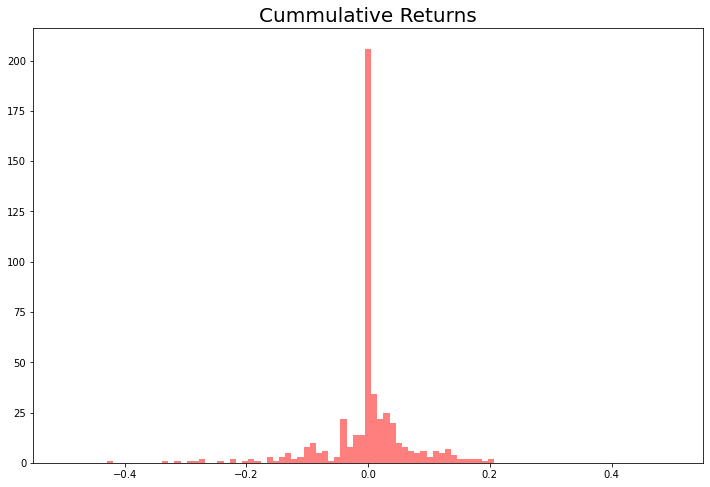

mean of treated less control: -0.0010236837773600533


In [603]:

#CUMMULATIVE RETURNS**************************
fig, ax = plt.subplots(figsize = (12,6))
plt.plot(diff,color = 'r', alpha = 0.2)
plt.title('Difference in Cummulative Returns', fontsize = 20)
plt.show()
print(f'treated less control mean: {diff.iloc[-1,:].mean()}') #, f'\ntreated mean: {treated_results.iloc[-1,:].mean()}')
#plt.title

minim, maxim = np.round(diff.iloc[-1,:].min()), np.round(diff.iloc[-1,:].max())
bins = np.linspace(-0.5,0.5, 100)
fig, ax = plt.subplots(figsize = (12,8))
plt.hist(diff.iloc[-1,:], bins, color = 'r', alpha=0.5, label='treated')
plt.title('Cummulative Returns', fontsize = 20)
plt.show()
print(f'mean of treated less control: {diff.iloc[-1,:].mean()}')

In [604]:
control_rets = control_results.pct_change().dropna()
treated_rets = treated_results.pct_change().dropna()
#print(control_rets.mean(), treated_rets.mean())
# fig, ax = plt.subplots(figsize = (10,8))
# plt.hist(control_rets,color = 'r', alpha = 0.3) #.iloc[-1,:])
# plt.hist(treated_rets) #, color = 'b', alpha = 0.3)
# #plt.title('Covariance Matrix', fontsize = 20) # title with fontsize 20
# plt.show()

### Cummulative Returns

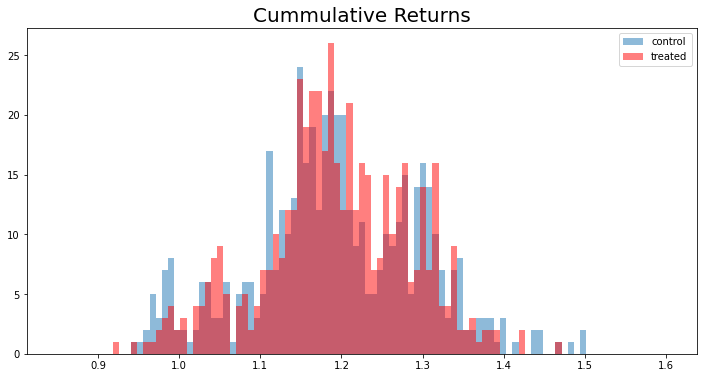

conrol mean: 1.1938777800181477 
treated mean: 1.192854096240787


In [442]:
bins = np.linspace(0.85, 1.6, 100)

fig, ax = plt.subplots(figsize = (12,6))
plt.hist(control_results.iloc[-1,:], bins, alpha=0.5, label='control')
plt.hist(treated_results.iloc[-1,:], bins, color = 'r', alpha=0.5, label='treated')
plt.legend(loc='upper right')
plt.title('Cummulative Returns', fontsize = 20)
plt.show()
print(f'conrol mean: {control_results.iloc[-1,:].mean()}', f'\ntreated mean: {treated_results.iloc[-1,:].mean()}')

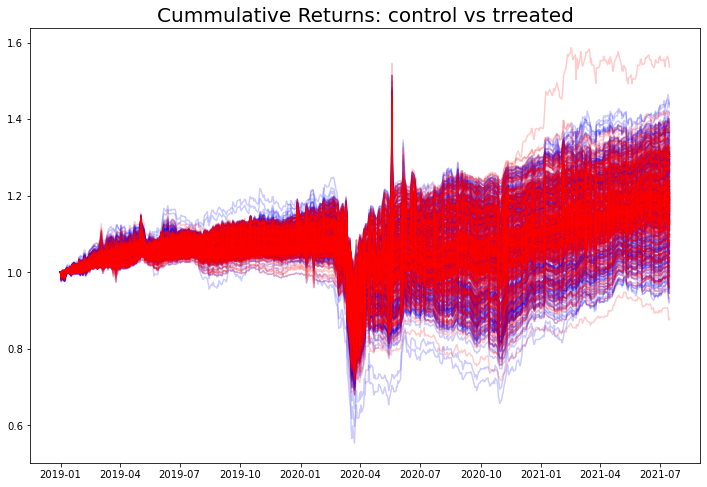

In [608]:
fig, ax = plt.subplots(figsize = (12,8))
plt.plot(control_results,color = 'b', alpha = 0.2) #.iloc[-1,:])
plt.plot(treated_results, color = 'r', alpha = 0.2)
plt.title('Cummulative Returns: control vs trreated' , fontsize = 20)

#plt.title('Covariance Matrix', fontsize = 20) # title with fontsize 20
plt.show()

### Annualized Returns

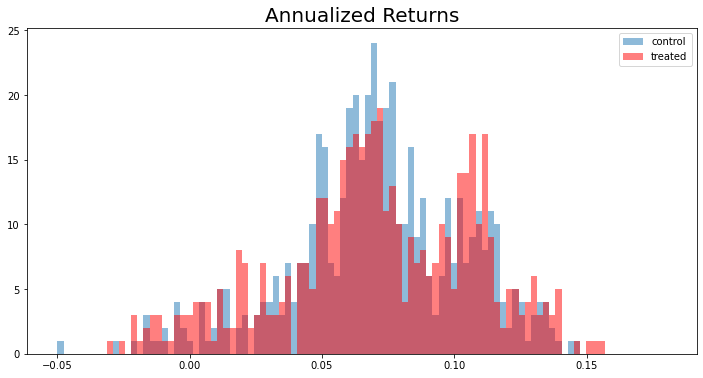

control mean: 0.07078458141465722 
treated mean: 0.07131863426071207


In [609]:
treated_ann_rets = pa.annualize_rets(treated_rets,260)
control_ann_rets = pa.annualize_rets(control_rets,260)

bins = np.linspace(-0.05, 0.18, 100)
fig, ax = plt.subplots(figsize = (12,6))
plt.hist(treated_ann_rets, bins, alpha=0.5, label='control')
plt.hist(control_ann_rets, bins, color = 'r', alpha=0.5, label='treated')
plt.legend(loc='upper right')
plt.title('Annualized Returns', fontsize = 20)
plt.show()
print(f'control mean: {control_ann_rets.mean()}', f'\ntreated mean: {treated_ann_rets.mean()}')

##### *** Treated returns have a slightly greater annualized return

### Sharpe Ratio

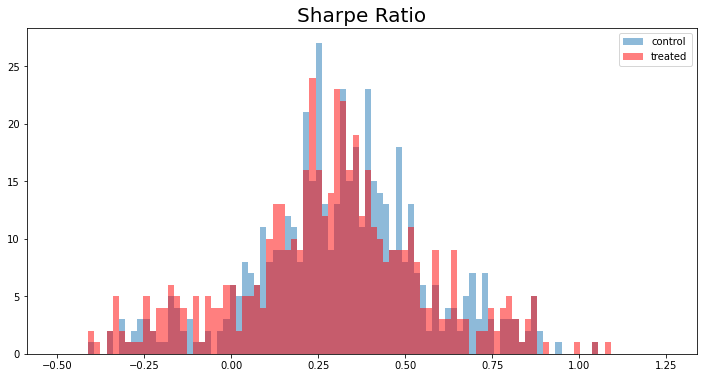

control mean: 0.28780826180418984 
treated mean: 0.3123471316384704


In [610]:
#plt.hist(pa.sharpe_ratio(treated_rets, 0.028, periods_per_year=260))

treated_sharpe = pa.sharpe_ratio(treated_rets, 0.028, periods_per_year=260)
control_sharpe = pa.sharpe_ratio(control_rets, 0.028, periods_per_year=260)


bins = np.linspace(-0.5, 1.25, 100)
fig, ax = plt.subplots(figsize = (12,6))
plt.hist(treated_sharpe, bins, alpha=0.5, label='control')
plt.hist(control_sharpe, bins, color = 'r', alpha=0.5, label='treated')
plt.legend(loc='upper right')

plt.title('Sharpe Ratio', fontsize = 20)
plt.show()
print(f'control mean: {control_sharpe.mean()}', f'\ntreated mean: {treated_sharpe.mean()}')

##### *** Treated portfolios have higher Sharpe Ratio

#### Findings
- significant difference in cummulative returns, for the better
- significant difference in average Sharpe Ratio, for the better.

### What next?
- Develop better porfolio construction methods to exploit benefits of theses independent assets. Liability Driven Investment and other methods that hold safe assets and expose only a portion to risky assets will be able to leverage the unique properties of NFTRCI.

## Thank You